# [📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using Effects, MultipleTesting
using GLM, MLJGLMInterface, StableRNGs
import AnovaGLM as aov

using MLJ: schema

In [2]:
include("pubh.jl");
set_default_plot_size(15cm, 12cm)
@rlibrary readr
@rimport pubh

# Univariate Analysis

## Comparing two levels

In [3]:
R"""
data(Oncho, package="pubh")
oncho = as.data.frame(Oncho)
""";

In [4]:
@rget oncho
oncho |> head

5×7 DataFrame
 Row │ id       mf            area        agegrp  sex     mfload   lesions 
     │ Float64  Cat…          Cat…        Cat…    Cat…    Float64  Cat…    
─────┼─────────────────────────────────────────────────────────────────────
   1 │     1.0  Infected      Savannah    20-39   Female      1.0  No
   2 │     2.0  Infected      Rainforest  40+     Male        3.0  No
   3 │     3.0  Infected      Savannah    40+     Female      1.0  No
   4 │     4.0  Not-infected  Rainforest  20-39   Female      0.0  No
   5 │     5.0  Not-infected  Savannah    40+     Female      0.0  No

In [5]:
#| code-fold: true
tabulate(oncho, :mf, :area) |> print

   |              |         area          |       
   |              | Rainforest | Savannah | Total 
--------------------------------------------------
mf | Not-infected |        213 |      267 |   480 
   |     Infected |        541 |      281 |   822 
--------------------------------------------------
   |        Total |        754 |      548 |  1302 


# Logistic Regression Model

For a logistic model, we will use an extension of the multiple linear regression models known as generalised linear models (GLM) using the binomial family (for MLR, we used Gaussian errors).

In [6]:
oncho.mf_cont = coerce(oncho.mf, MLJ.Continuous) .- 1;

In [7]:
model_1 = glm(@formula(mf_cont ~ area), oncho, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mf_cont ~ 1 + area

Coefficients:
────────────────────────────────────────────────────────────────────────────
                     Coef.  Std. Error     z  Pr(>|z|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)       0.051106   0.0854637  0.60    0.5498  -0.1164     0.218612
area: Rainforest  0.881021   0.117675   7.49    <1e-13   0.650383   1.11166
────────────────────────────────────────────────────────────────────────────

When we exponentiate, we obtain the Odds Ratio:

In [8]:
 glm_coef(model_1 |> coeftable |> DataFrame)[2:end, :]

1×5 DataFrame
 Row │ Name              Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String            Float64  Float64    Float64    Float64  
─────┼───────────────────────────────────────────────────────────
   1 │ area: Rainforest    2.413      1.916      3.039       0.0

The default predicted values from a logistic model are probabilities, in our current example, the probability of being infected with *Onchocerciasis volvulus*.

We can use effects to predict the probabilities of being infected by *Onchocerciasis volvulus* when we use the inverse logit transformation:

In [9]:
eff_1 = effects(
	Dict(:area => unique(oncho.area)),
	model_1, invlink=inv_logit
)

2×5 DataFrame
 Row │ area        mf_cont   err        lower     upper    
     │ String      Float64   Float64    Float64   Float64  
─────┼─────────────────────────────────────────────────────
   1 │ Savannah    0.512774  0.021352   0.491422  0.534126
   2 │ Rainforest  0.717507  0.0163957  0.701111  0.733902

The predicted probabilities can be displayed in an effect plot.

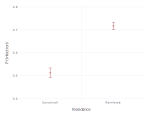

In [10]:
#| label: fig-fig1
#| fig-cap: "Effect of residence on microfilarial infection. Error represents 95% CIs around predicted probabilities."
effect_plot(
  eff_1,
  :area, :mf_cont,
  xlab="Residence",
	ylab="P (Infection)"
)

If we divide the deviance by the degrees of freedom we obtain an estimate of the overdispersion of the model. When this value is close to one (less than one, even better), it means that there is no overdispersion.

In [11]:
deviance(model_1) / dof_residual(model_1) |> r3

1.274

## Comparing more than two levels

In [12]:
#| code-fold: true
tabulate(oncho, :mf, :agegrp)

   |              |          agegrp           |       
   |              | 10-19 | 20-39 | 40+ | 5-9 | Total 
------------------------------------------------------
mf | Not-infected |   119 |   125 |  80 | 156 |   480 
   |     Infected |    99 |   299 | 378 |  46 |   822 
------------------------------------------------------
   |        Total |   218 |   424 | 458 | 202 |  1302 


Next, we fit a logistic linear regression model.

In [13]:
model_2 = glm(@formula(mf_cont ~ agegrp), oncho, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

mf_cont ~ 1 + agegrp

Coefficients:
──────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)    -1.22121    0.167778  -7.28    <1e-12  -1.55005   -0.892376
agegrp: 10-19   1.03721    0.215995   4.80    <1e-05   0.613869   1.46055
agegrp: 20-39   2.09334    0.198731  10.53    <1e-25   1.70384    2.48285
agegrp: 40+     2.77408    0.208074  13.33    <1e-39   2.36626    3.1819
──────────────────────────────────────────────────────────────────────────

In [14]:
glm_coef(model_2 |> coeftable |> DataFrame)[2:end, :]

3×5 DataFrame
 Row │ Name           Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String         Float64  Float64    Float64    Float64  
─────┼────────────────────────────────────────────────────────
   1 │ agegrp: 10-19    2.821      1.848      4.308       0.0
   2 │ agegrp: 20-39    8.112      5.495     11.975       0.0
   3 │ agegrp: 40+     16.024     10.658     24.092       0.0

In [15]:
eff_2 = effects(
	Dict(:agegrp => levels(oncho.agegrp)),
	model_2, invlink=inv_logit
)

4×5 DataFrame
 Row │ agegrp  mf_cont   err        lower     upper    
     │ String  Float64   Float64    Float64   Float64  
─────┼─────────────────────────────────────────────────
   1 │ 5-9     0.227723  0.0295062  0.198217  0.257229
   2 │ 10-19   0.454128  0.0337215  0.420407  0.48785
   3 │ 20-39   0.705189  0.0221433  0.683045  0.727332
   4 │ 40+     0.825328  0.0177416  0.807586  0.843069

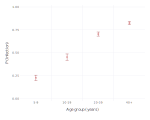

In [16]:
#| label: fig-fig2
#| fig-cap: "Effect of age group on microfilarial infection. Error represents 95% CIs around predicted probabilities."
effect_plot(
  eff_2,
  :agegrp, :mf_cont,
  xlab="Age group (years)",
	ylab="P (Infection)",
)

In the case where we really wanted to compare all age groups, we would need to perform a post-hoc analysis adjusting by multiple comparison

In [17]:
BH_adj(pvals) = MultipleTesting.adjust(PValues(pvals), BenjaminiHochberg());

In [18]:
empairs(model_2; dof=dof_residual, padjust=BH_adj)

6×6 DataFrame
 Row │ agegrp         mf_cont    err       dof      t          Pr(>|t|)    
     │ String         Float64    Float64   Float64  Float64    Float64     
─────┼─────────────────────────────────────────────────────────────────────
   1 │ 5-9 > 10-19    -1.03721   0.215995   1299.0   -4.80202  2.10362e-6
   2 │ 5-9 > 20-39    -2.09334   0.198731   1299.0  -10.5336   1.78005e-24
   3 │ 5-9 > 40+      -2.77408   0.208074   1299.0  -13.3322   2.54315e-37
   4 │ 10-19 > 20-39  -1.05613   0.172768   1299.0   -6.11301  1.93602e-9
   5 │ 10-19 > 40+    -1.73687   0.183439   1299.0   -9.46838  2.579e-20
   6 │ 20-39 > 40+    -0.680738  0.162757   1299.0   -4.18253  3.07622e-5

# Mutivariate Analysis

Once we have reproduced the results from the book, let’s make the correct analysis: a multivariate analysis. We will include all potential two-way interactions as our starting model and then proceede to model simplification.

We will start by defining our contrasts for the categorical variables.

In [19]:
oncho_cont = Dict(
	:agegrp => EffectsCoding(),
	:area => EffectsCoding(),
	:sex => EffectsCoding()
);

In [20]:
model_3 = glm(
	@formula(mf_cont ~ agegrp*area + agegrp*sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_3; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + agegrp & area + agegrp & sex + area & sex

Table:
─────────────────────────────────────────────────
               DOF  Deviance        χ²  Pr(>|χ²|)
─────────────────────────────────────────────────
(Intercept)      1   1701.08    9.6622     0.0019
agegrp           3   1435.87  265.2054     <1e-56
area             1   1385.21   50.6656     <1e-11
sex              1   1367.83   17.3754     <1e-04
agegrp & area    3   1362.55    5.2849     0.1521
agegrp & sex     3   1356.00    6.5488     0.0878
area & sex       1   1350.36    5.6394     0.0176
─────────────────────────────────────────────────



## Model Simplification

Let’s remove the interaction between area and age group.

In [21]:
model_4 = glm(
	@formula(mf_cont ~ agegrp+area + agegrp*sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_4; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + agegrp & sex + area & sex

Table:
────────────────────────────────────────────────
              DOF  Deviance        χ²  Pr(>|χ²|)
────────────────────────────────────────────────
(Intercept)     1   1726.25    7.5626     0.0060
agegrp          3   1449.66  276.5864     <1e-58
area            1   1386.35   63.3184     <1e-14
sex             1   1367.29   19.0591     <1e-04
agegrp & sex    3   1361.23    6.0564     0.1089
area & sex      1   1355.64    5.5860     0.0181
────────────────────────────────────────────────



Let's take a look at the model without the age group and sex interaction.

In [22]:
model_5 = glm(
	@formula(mf_cont ~ agegrp+area + agegrp+sex + area*sex), 
	oncho, Binomial(), LogitLink(),
	contrasts = oncho_cont
)

aov.anova(model_5; type=3)

Analysis of Variance

Type 3 test / Likelihood-ratio test

mf_cont ~ 1 + agegrp + area + sex + area & sex

Table:
───────────────────────────────────────────────
             DOF  Deviance        χ²  Pr(>|χ²|)
───────────────────────────────────────────────
(Intercept)    1   1725.01    7.8006     0.0052
agegrp         3   1449.17  275.8460     <1e-58
area           1   1385.77   63.3921     <1e-14
sex            1   1366.10   19.6711     <1e-05
area & sex     1   1361.70    4.4028     0.0359
───────────────────────────────────────────────



## Model comparisons

Comparing the BIC of the multivariate models:

In [23]:
bic(model_3) |> r3, bic(model_4) |> r3, bic(model_5) |> r3

(1443.591, 1427.361, 1411.902)

Comparing AIC:

In [24]:
aic(model_3) |> r3, aic(model_4) |> r3, aic(model_5) |> r3

(1376.359, 1375.644, 1375.7)

Comparing pseudo-r²:

In [25]:
r2(model_3, :Nagelkerke) |> r3, r2(model_4, :Nagelkerke) |> r3, r2(model_5, :Nagelkerke) |> r3

(0.333, 0.329, 0.324)

## Table of coefficients

In [26]:
glm_coef(model_4 |> coeftable |> DataFrame)[2:end, :]

9×5 DataFrame
 Row │ Name                            Coef.    Lower 95%  Upper 95%  Pr(>|z|) ⋯
     │ String                          Float64  Float64    Float64    Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ agegrp: 10-19                     0.548      0.428      0.702     0.0   ⋯
   2 │ agegrp: 20-39                     2.312      1.854      2.882     0.0
   3 │ agegrp: 40+                       3.756      2.996      4.71      0.0
   4 │ area: Rainforest                  1.727      1.505      1.982     0.0
   5 │ sex: Female                       0.733      0.637      0.843     0.0   ⋯
   6 │ agegrp: 10-19 & sex: Female       0.817      0.638      1.047     0.11
   7 │ agegrp: 20-39 & sex: Female       0.95       0.762      1.185     0.652
   8 │ agegrp: 40+ & sex: Female         1.29       1.029      1.618     0.027
   9 │ area: Rainforest & sex: Female    1.18       1.028      1.354     0.018 ⋯

## Effect plots

In [27]:
eff_4 = effects(
	Dict(
		:agegrp => levels(oncho.agegrp),
		:area => levels(oncho.area),
		:sex => levels(oncho.sex)
	),
	model_4, invlink=inv_logit
)

eff_4 |> head

5×7 DataFrame
 Row │ sex     agegrp  area      mf_cont    err        lower      upper    
     │ String  String  String    Float64    Float64    Float64    Float64  
─────┼─────────────────────────────────────────────────────────────────────
   1 │ Male    5-9     Savannah  0.193048   0.0413163  0.151732   0.234365
   2 │ Female  5-9     Savannah  0.0841793  0.0225377  0.0616416  0.106717
   3 │ Male    10-19   Savannah  0.43279    0.0599503  0.37284    0.492741
   4 │ Female  10-19   Savannah  0.164208   0.0351158  0.129093   0.199324
   5 │ Male    20-39   Savannah  0.734427   0.0414445  0.692982   0.775871

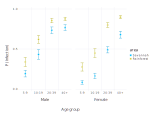

In [28]:
#| label: fig-fig3
#| fig-cap: "Effect of age group on microfilarial infection by residence and sex."
plot(
  eff_4,
  x=:agegrp, y=:mf_cont, xgroup=:sex,
  color=:area,
  ymin=:lower, ymax=:upper,
  Geom.subplot_grid(
    Geom.point,
    Geom.errorbar
    ),
  Guide.xlabel("Age group"),
  Guide.ylabel("P (Infection)"),
  Theme(default_color="Firebrick")
)

# MLJ Approach

## Pre-processing

In [29]:
@select!(oncho, :mf, :area, :agegrp, :sex);

In [30]:
y, x = unpack(oncho, ==(:mf));

In [31]:
lbc = @load LinearBinaryClassifier pkg=GLM verbosity=0
pipe = 	ContinuousEncoder(drop_last=true) |> lbc

ProbabilisticPipeline(
  continuous_encoder = ContinuousEncoder(
        drop_last = true, 
        one_hot_ordered_factors = false), 
  linear_binary_classifier = LinearBinaryClassifier(
        fit_intercept = true, 
        link = LogitLink(), 
        offsetcol = nothing, 
        maxiter = 30, 
        atol = 1.0e-6, 
        rtol = 1.0e-6, 
        minstepfac = 0.001, 
        report_keys = [:deviance, :dof_residual, :stderror, :vcov, :coef_table]), 
  cache = true)

In [32]:
mach = machine(pipe, x, y) |> fit!;

[ Info: Training machine(ProbabilisticPipeline(continuous_encoder = ContinuousEncoder(drop_last = true, …), …), …).
[ Info: Training machine(:continuous_encoder, …).
[ Info: Training machine(:linear_binary_classifier, …).


In [33]:
fitted_params(mach).linear_binary_classifier.features

5-element Vector{Symbol}:
 :area__Savannah
 Symbol("agegrp__5-9")
 Symbol("agegrp__10-19")
 Symbol("agegrp__20-39")
 :sex__Male

In [34]:
report(mach).linear_binary_classifier.coef_table |> DataFrame

6×7 DataFrame
 Row │ Name            Coef.      Std. Error  z          Pr(>|z|)     Lower 95 ⋯
     │ String          Float64    Float64     Float64    Float64      Float64  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ area__Savannah  -1.1227      0.138614   -8.09945  5.52062e-16  -1.39438 ⋯
   2 │ agegrp__5-9     -2.87127     0.217113  -13.2248   6.31307e-40  -3.2968
   3 │ agegrp__10-19   -1.92839     0.194454   -9.91692  3.51418e-23  -2.30951
   4 │ agegrp__20-39   -0.52348     0.169111   -3.09547  0.001965     -0.85493
   5 │ sex__Male        0.581303    0.135641    4.28561  1.82241e-5    0.31545 ⋯
   6 │ (Intercept)      1.79698     0.159195   11.2879   1.50624e-29   1.48496
                                                               2 columns omitted

In [35]:
glm_coef(
  report(mach).linear_binary_classifier.coef_table |> 
  DataFrame
)[1:end-1, :]

5×5 DataFrame
 Row │ Name            Coef.    Lower 95%  Upper 95%  Pr(>|z|) 
     │ String          Float64  Float64    Float64    Float64  
─────┼─────────────────────────────────────────────────────────
   1 │ area__Savannah    0.325      0.248      0.427     0.0
   2 │ agegrp__5-9       0.057      0.037      0.087     0.0
   3 │ agegrp__10-19     0.145      0.099      0.213     0.0
   4 │ agegrp__20-39     0.592      0.425      0.825     0.002
   5 │ sex__Male         1.788      1.371      2.333     0.0

## Performance

In [36]:
oncho_ŷ = MLJ.predict(mach)
oncho_ȳ = predict_mode(mach);

In [37]:
cross_entropy(oncho_ŷ, y) |> r3

0.525

In [38]:
misclassification_rate(oncho_ȳ, y) |> r3

0.256

In [39]:
accuracy(oncho_ȳ, y) |> r3

0.744

In [40]:
sensitivity(oncho_ȳ, y) |> r3

┌ Warning: Levels not explicitly ordered. Using the order CategoricalValue{String, UInt32}["Not-infected", "Infected"]. The "positive" level is Infected. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.882

In [41]:
specificity(oncho_ȳ, y) |> r3

┌ Warning: Levels not explicitly ordered. Using the order CategoricalValue{String, UInt32}["Not-infected", "Infected"]. The "positive" level is Infected. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.508

In [42]:
oncho_roc = roc_curve(oncho_ŷ, y);

┌ Warning: Levels not explicitly ordered. Using the order ["Not-infected", "Infected"]. The "positive" level is Infected. 
└ @ StatisticalMeasures ~/.julia/packages/StatisticalMeasures/Wnt7C/src/roc.jl:28


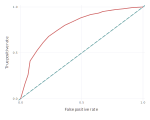

In [43]:
plot(
  x=oncho_roc[1], 
  y=oncho_roc[2],
  Geom.line,
  intercept=[0], slope=[1], 
  Geom.abline(color="cadetblue", style=:dash),
  Guide.xlabel("False positive rate"),
  Guide.ylabel("True positive rate"),
  Theme(default_color="IndianRed", line_width=0.7mm)
)

In [44]:
auc(oncho_ŷ, y) |> r3

0.792